In [1]:
"""
Name: example_probabilistic_model.ipynb
Authors: Stephan Meighen-Berger
Constructs a probabilistic model which can be used instead of the cpu heavy simulation
"""

'\nName: example_probabilistic_model.ipynb\nAuthors: Stephan Meighen-Berger\nConstructs a probabilistic model which can be used instead of the cpu heavy simulation\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
# Reuse sim data
config['scenario']['class'] = 'New'
config['scenario']["statistics storage"]["name"] = "probabilistic"
# Some example settings
config['scenario']['population size'] = 2
config['scenario']['duration'] = 6000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1e-2
config['scenario']['injection']['y range'] = [6.9, 7.1]
config['scenario']['light prop'] = {
            "switch": False,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": False,
}
# Organisms
config['organisms']['emission fraction'] = 0.1
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # using grid files
config['water']['model']['off set'] = np.array([0., 2.5])
config['water']['model']['directory'] = "../data/current/Long_run_corr/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0

In [9]:
runs = 5
alphas = [1e1, 1e0, 1e-1, 1e-2]
alpha_x_arr = []
alpha_norm_arr = []
for alpha in alphas:
    run_x = []
    run_norm = []
    for seed in tqdm(range(runs)):
        # Seed
        config['general']["random state seed"] = seed
        # Alpha
        config['organisms']['alpha'] = alpha
        # Creating a fourth_day object
        fd = Fourth_Day()
        # Launching solver
        fd.sim()
        # Analyzing data
        x_loc = []
        for stat in fd.statistics:
            tmp = stat["pos_x"].values[stat["pulse start"].values]
            if len(tmp) > 0:
                x_loc.append(tmp)
            else:
                continue
        x_loc = np.concatenate(x_loc).ravel()
        run_x.append(x_loc)
        # Normalization
        norm_fac = []
        for x_l in x_loc:
            norm_fac.append(len(
                fd.statistics[-1]["pos_x"].values[np.where(fd.statistics[-1]["pos_x"].values >= x_l ) ]
            ))
        norm_fac = np.array(norm_fac)
        run_norm.append(norm_fac)
    run_x = np.concatenate(run_x).ravel()
    run_norm = np.concatenate(run_norm).ravel() * runs
    alpha_x_arr.append(run_x)
    alpha_norm_arr.append(run_norm)

  0%|                                                                                                                                 | 0/5 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


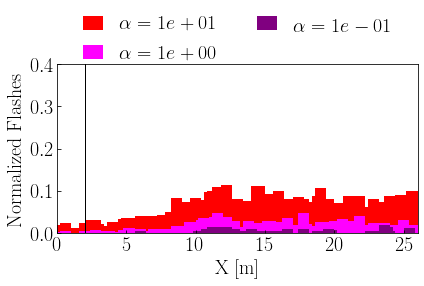

In [11]:
# Energy distributions
edgecolors = ['r', 'magenta', 'purple', 'b']
alphas_plt = [1., 1., 1., 1.]
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for id_alpha, alpha in enumerate(alphas[:-1]):
    counts, edges = np.histogram(alpha_x_arr[id_alpha],
                        bins=np.linspace(0., 26., 131),
                        weights=1./alpha_norm_arr[id_alpha]
                        )
    hist = ax1.bar(edges[:-1],
                    counts,
                    color=edgecolors[id_alpha],
                    alpha=alphas_plt[id_alpha],
                    label=r'$\alpha = %.e$' % alpha,
                    lw=lw)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='k', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 0.4)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()

In [12]:
figure.savefig(PICS + "7m_injection_pdf.pdf",
               bbox_inches='tight')